In [1]:
import time
import gym
import numpy as np
import control as ct
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.regularizers as reg
from tensorflow_probability import distributions as tfd
import matplotlib.pyplot as plt
import os
tf.enable_eager_execution()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
class MVNFull():
    def __init__(self, loc,covariance_matrix):
        self.loc = loc
        self.cov = covariance_matrix
        self.shape = tf.cast(self.cov.shape[-1],dtype=tf.float64)
#         print(self.loc.shape)
#         print(self.cov.shape)
        assert(self.loc.shape[-2]==self.cov.shape[-1]), "mean and covariance must have same n"
        assert(self.cov.shape[-1]==self.cov.shape[-2]),'covariance must have shape [...,n,n]'
        
    def log_prob(self, value):
        value = value
#         print('Inside prob function')
#         print('value',value.shape)
        assert(value.shape[-1]==self.loc.shape[-1] and value.shape[-2]==self.loc.shape[-2]),'value must have same last 2 dimensions as loc'
#         print('cov',self.cov.shape)

#         print('cov',self.cov)
        cov_inv = tf.linalg.inv(self.cov+1e-4*tf.eye(self.shape,dtype=tf.float64))
#         cov_inv = None
#         multiplier = 1e-8
#         while cov_inv == None:
#             try:
#                 if multiplier != 1e-8:
#                     print('MVNFull covariance inverser failed, trying identity multiplier ',multiplier)
#                 cov_inv = tf.linalg.inv(self.cov+multiplier*tf.eye(self.shape, dtype = tf.float64))
#             except:
#                 multiplier *= 10

                
                
#         print('cov_inv',cov_inv)
#         print('cov_inv',cov_inv.shape)
#         print(cov_inv.numpy())
        cov_det = tf.linalg.det(self.cov)
#         print('cov_det', cov_det.shape)
#         print(cov_det.numpy())
        denomenator = tf.math.sqrt(tf.math.pow((tf.cast(2*np.pi,dtype = tf.float64)),self.shape)*cov_det)
#         print('denomenator', denomenator.numpy())
        diff = value-self.loc
#         print('diff', diff.numpy())
        numerator = tf.squeeze(tf.math.exp((-0.5)*tf.matmul(tf.matmul(diff,cov_inv, transpose_a=True),diff)))
#         print('numerator', numerator.numpy())
#         print('final value', tf.math.log(tf.math.divide(numerator,denomenator)).numpy())
#         print('leaving prob function')
        return tf.math.log(tf.math.divide(numerator,denomenator)+1e-32)

In [22]:
def forward_filter_fn(A,B,u,g,C,sigma,l_a_posteriori,P_a_posteriori,z):
    '''Calculates prior distribution based on the previous posterior distribution
        and the current residual updates posterior distribution based on the new
        prior distribution
    '''
#     print('z',z)
#     print('A', A)
#     print('B',B)
#     print('u',u)
#     print('g',g)
#     print('sigma',sigma)
#     print('C', C)
#     print('l_a_posteriori', l_a_posteriori)
#     print('P_a_posteriori', P_a_posteriori)
    _I = tf.eye(int(A.shape[0]), dtype = tf.float64)
    
    z = tf.expand_dims(z,-1)
    l_a_priori = tf.matmul(A,l_a_posteriori) + tf.matmul(B,u)
#     print('l_a_priori',l_a_priori)
    P_a_priori = tf.matmul(tf.matmul(A,P_a_posteriori), A, transpose_b = True) + tf.matmul(g,g, transpose_b=True)
#     print('P_a_priori',P_a_priori)
    y_pre = z - tf.matmul(C,l_a_priori)
#     print('y_pre', y_pre)

    S = tf.matmul(sigma, sigma, transpose_b=True) + \
        tf.matmul(tf.matmul(C, P_a_priori), C, transpose_b=True)
#     print('S',S)
    S_inv = tf.linalg.inv(S+1e-4*tf.eye(int(C.shape[0]), dtype = tf.float64))
#     S_inv = None
#     try:
#         S_inv = tf.linalg.inv(S)
#         print('success?')
#     except InvalidArgumentError:
#         print('Outer except')
#         multiplier = 1e-10
#         while S_inv == None:
#             try:
#                 if multiplier != 1e-10:
#                     print('KF inv failed, trying identity multiplier ',multiplier)
#                 cov_inv = tf.linalg.inv(self.cov+multiplier*tf.eye(S.shape[0], dtype = tf.float64))
#             except InvalidArgumentError:
#                 multiplier *= 10
#         pass


#     print('S_inv', S_inv)
    K = tf.matmul(tf.matmul(P_a_priori, C, transpose_b=True), S_inv)
#     print('K', K)
    l_a_posteriori = l_a_priori + tf.matmul(K,y_pre)
#     print('l_a_posteriori', l_a_posteriori)
    I_KC = _I-tf.matmul(K,C)
#     print('I-KC', I_KC)
    P_a_posteriori = tf.matmul(tf.matmul(I_KC, P_a_priori), I_KC, transpose_b=True) + \
                        tf.matmul(tf.matmul(K,tf.matmul(sigma, sigma, transpose_b = True)),
                                K, transpose_b=True)
#     print('P_a_posteriori',P_a_posteriori)
    y_post = z-tf.matmul(C,l_a_posteriori)
#     print('y_post', y_post)
    pred = tf.matmul(C, l_a_posteriori)
#     print('pred', pred)
        
    return A,B,u,g,C,sigma,l_a_posteriori,P_a_posteriori,z

# Old Version

In [9]:
def build_LSTM(lstm_sizes):
    with tf.GradientTape() as tape:
        lstms = [tf.contrib.rnn.LSTMCell(size, reuse=tf.get_variable_scope().reuse) for size in lstm_sizes]
        dropouts = [tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob = 0.5) for lstm in lstms]

        cell = tf.contrib.rnn.MultiRNNCell(dropouts)
        return cell

class model(object):
    def __init__(self):
        self.m = 4
        self.dim_z = self.m
        self.n = 4
        self.r = 1
        self.lstm_input_dim = self.m+4
        self.sigma_upper_bound = 1
        self.sigma_lower_bound = 0
        self.g_upper_bound = 1
        self.g_lower_bound = 0.1
        self.mu_0_upper_bound = 1
        self.mu_0_lower_bound = 0
        self.Sigma_0_upper_bound = 1
        self.Sigma_0_lower_bound = 0
        self.beta = 0.01
        self.b_upper_bound = 0.25
        self.b_lower_bound = -0.25
        thetaacc_error = 0
        initial_state_variation = 0.1
        
        self.optimizer = tf.train.AdamOptimizer()

        self.initial_variance_estimate = 1

        self.lstm_sizes = [128,64]
        self.env = gym.make('Custom_CartPole-v0', thetaacc_error=thetaacc_error, initial_state=initial_state_variation)
        gravity = self.env.gravity
        cart_mass = self.env.masscart
        pole_mass = self.env.masspole
        pole_length = self.env.length
        self.env_params = tf.expand_dims(np.array([gravity, cart_mass,pole_mass,pole_length],
                                             dtype=np.float64),0)
#     def affine_transformation(self,lstm_output, first=False):
#         if first:
#             mu_0 = tf.reshape(layers.Dense(m, kernel_regularizer = reg.l2(self.beta),
#                                            bias_regularizer = reg.l2(self.beta),
#                                            name = 'mu_0dense')(lstm_output), shape=(m,1))
#             mu_0 = ((mu_0_upper_bound-mu_0_lower_bound)/(1+tf.exp(-mu_0)))+mu_0_lower_bound
#             Sigma_0 = tf.reshape(layers.Dense(m, kernel_regularizer = reg.l2(self.beta),
#                                               bias_regularizer = reg.l2(self.beta),
#                                               name = 'Sigma_0dense')(lstm_output),shape = (m,1))
#             Sigma_0 = ((Sigma_0_upper_bound-Sigma_0_lower_bound)/(1+tf.exp(-Sigma_0)))+Sigma_0_lower_bound
#             Sigma_0 = tf.matmul(Sigma_0,Sigma_0,transpose_b=True)+tf.eye(4, dtype=tf.float64)*0.001
#             l_0_distribution = tfd.MultivariateNormalFullCovariance(loc = tf.squeeze(mu_0),
#                                                                     covariance_matrix= Sigma_0,
#                                                                     validate_args=True)
#             l_0 = tf.expand_dims(l_0_distribution.sample(),1)
#             return mu_0,Sigma_0,l_0
#         A = tf.reshape(layers.Dense(m*n, kernel_regularizer = reg.l2(beta),
#                                     bias_regularizer = reg.l2(beta),
#                                     name = 'A_dense')(lstm_output),shape=(m,n))
#         B = tf.reshape(layers.Dense(m*r, kernel_regularizer = reg.l2(beta),
#                                     bias_regularizer = reg.l2(beta),
#                                     name = 'B_dense')(lstm_output),shape=(m,r))
#         g = tf.reshape(layers.Dense(m, kernel_regularizer = reg.l2(beta),
#                                     bias_regularizer = reg.l2(beta),
#                                     name = 'g_dense')(lstm_output),shape = (m,1))
#         g = ((g_upper_bound-g_lower_bound)/(1+tf.exp(-g)))+g_lower_bound
#         sigma = tf.reshape(layers.Dense(dim_z, kernel_regularizer = reg.l2(beta),
#                                         bias_regularizer = reg.l2(beta),
#                                         name = 'sigma_dense')(lstm_output),shape=(dim_z,1))
#         sigma = ((sigma_upper_bound-sigma_lower_bound)/(1+tf.exp(-sigma)))+sigma_lower_bound
#         return A,B,g,sigma
    def likelihood_fn(self,params, inputs):
        with tf.GradientTape() as tape:
            A, B, u, g, C, sigma, l_filtered, P_filtered = inputs
            mu_1, Sigma_1 = params
        #     print('A',len(A))
        #     print('B',len(B))
        #     print('u',len(u))
        #     print('C',len(C))
        #     print('g',len(g))
        #     print('sigma',len(sigma))
        #     print('l_filtered',len(l_filtered))
        #     print('p_filtered',len(P_filtered))
        #     print('mu_1',mu_1.shape)
        #     print('Sigma_1',Sigma_1.shape)
            mu = [mu_1]
            Sigma = [Sigma_1]
            assert(len(A)==len(B) and len(B)==len(u) and len(u)==len(C) and len(C)==len(sigma) and 
                   len(sigma)==len(l_filtered) and len(l_filtered)==len(P_filtered)),"Not all sequences are same length"
            for i in range(len(A)):
                mu.append(tf.matmul(C[i], tf.add(tf.matmul(A[i],l_filtered[i]), tf.matmul(B[i],u[i]))))
                temp = tf.matmul(tf.matmul(A[i], P_filtered[i]), A[i], transpose_b=True) + \
                            tf.matmul(g[i], g[i], transpose_b=True)
                Sigma.append(tf.matmul(tf.matmul(C[i], temp), C[i], transpose_b=True) + \
                             tf.matmul(sigma[i],sigma[i],transpose_b=True))
            return mu,Sigma
    def calculate_loss(self, all_KF_params, mu_0,Sigma_0):
        with tf.GradientTape() as tape:
            A_all,B_all,u_all,g_all,C_all,sigma_all,l_a_posteriori,P_a_posteriori,env_states = all_KF_params
            mu_1 = tf.add(tf.matmul(A_all[0], mu_0),tf.matmul(B_all[0],u_all[0]))
            Sigma_1 = tf.add(tf.matmul(tf.matmul(C_all[0],Sigma_0),C_all[0], transpose_b=True),tf.matmul(sigma_all[0],sigma_all[0],
                                                                                    transpose_b=True))
        #     print(mu_1.shape)
        #     print(Sigma_1.shape)

            likelihoods = []
            if self.rewards > 1:
                mu,Sigma = self.likelihood_fn((mu_1,Sigma_1),(A_all,B_all,u_all,g_all,
                                                         C_all,sigma_all,
                                                         l_a_posteriori[1:],P_a_posteriori[1:]))
        #     print('mu',len(mu),mu[0].shape)
        #     print('Sigma',len(Sigma),Sigma[0].shape)
    #         print('rewards',self.rewards)
    #         print('env_states', len(env_states))
            for i in range(self.rewards):
                z_distribution = MVNFull(loc = mu[i], covariance_matrix = \
                                         0.0001*tf.eye(self.m, dtype = tf.float64)+Sigma[i])
    #             print(id(z_distribution))
                likelihoods.append(z_distribution.log_prob(env_states[i]))
            loss = tf.Variable([0.0], dtype = tf.float64)
    #         print(len(likelihoods),id(likelihoods))
            for item in likelihoods:
        #         print(item)
                loss = tf.add(loss,-item)
            return loss
    
    def train(self,epochs):
        losses = []
        for _ in range(epochs):
            self.rewards = 0
            A_all = []
            B_all = []
            u_all = []
            g_all = []
            C_all = []
            sigma_all = []
            l_a_posteriori = []
            P_a_posteriori = []
            env_states = []
            all_KF_params = [A_all,B_all,u_all,g_all,C_all,sigma_all,l_a_posteriori,P_a_posteriori,env_states]

            '''Build LSTM'''
            with tf.GradientTape() as tape:
                cell = build_LSTM(self.lstm_sizes)
                '''Get initial lstm state and input, get first output/state'''
                initial_state = cell.get_initial_state(batch_size=1,dtype = tf.float64)
                initial_input = tf.concat((self.env_params, np.zeros(shape = [1,4])),axis=1)
                output_single, state_single = cell(inputs=initial_input, state=initial_state)
    #             mu_0,Sigma_0,l_0 = self.affine_transformation(output_single,first=True)
                '''Calculate mu_0,Sigma_0, distribution using initial LSTM output'''
                mu_0 = tf.reshape(layers.Dense(self.m, kernel_regularizer = reg.l2(self.beta),
                                               bias_regularizer = reg.l2(self.beta),
                                               name = 'mu_0dense')(output_single), shape=(self.m,1))
                mu_0 = ((self.mu_0_upper_bound-self.mu_0_lower_bound)/(1+tf.exp(-mu_0)))+self.mu_0_lower_bound
                Sigma_0 = tf.reshape(layers.Dense(self.m, kernel_regularizer = reg.l2(self.beta),
                                                  bias_regularizer = reg.l2(self.beta),
                                                  name = 'Sigma_0dense')(output_single),shape = (self.m,1))
                Sigma_0 = ((self.Sigma_0_upper_bound-self.Sigma_0_lower_bound)/(1+tf.exp(-Sigma_0)))+self.Sigma_0_lower_bound
                Sigma_0 = tf.matmul(Sigma_0,Sigma_0,transpose_b=True)+tf.eye(4, dtype=tf.float64)*0.001
                l_0_distribution = tfd.MultivariateNormalFullCovariance(loc = tf.squeeze(mu_0),
                                                                        covariance_matrix= Sigma_0,
                                                                        validate_args=True)
                l_0 = tf.expand_dims(l_0_distribution.sample(),1)



                # u_all.append(tf.zeros(shape = [1,r], dtype=tf.float64))
                l_a_posteriori.append(l_0)
                P_a_posteriori.append(self.initial_variance_estimate*tf.eye(self.m, dtype = tf.float64))


                observation=self.env.reset()
                # env_states.append(tf.expand_dims(tf.convert_to_tensor(observation,dtype=tf.float64),-1))
                done = False
                while not done:
                    self.env.render()
                    '''Get lstm outputs'''
                    A = tf.reshape(layers.Dense(self.m*self.n, kernel_regularizer = reg.l2(self.beta),
                                                bias_regularizer = reg.l2(self.beta),
                                                name = 'A_dense')(output_single),shape=(self.m,self.n))
                    B = tf.reshape(layers.Dense(self.m*self.r, kernel_regularizer = reg.l2(self.beta),
                                                bias_regularizer = reg.l2(self.beta),
                                                name = 'B_dense')(output_single),shape=(self.m,self.r))
                    g = tf.reshape(layers.Dense(self.m, kernel_regularizer = reg.l2(self.beta),
                                                bias_regularizer = reg.l2(self.beta),
                                                name = 'g_dense')(output_single),shape = (self.m,1))
                    g = ((self.g_upper_bound-self.g_lower_bound)/(1+tf.exp(-g)))+self.g_lower_bound
                    sigma = tf.reshape(layers.Dense(self.dim_z, kernel_regularizer = reg.l2(self.beta),
                                                    bias_regularizer = reg.l2(self.beta),
                                                    name = 'sigma_dense')(output_single),shape=(self.dim_z,1))
                    sigma = ((self.sigma_upper_bound-self.sigma_lower_bound)/(1+tf.exp(-sigma)))+self.sigma_lower_bound

    #                 A, B, g, sigma = self.affine_transformation(output_single)
                    no_control = tf.zeros(shape = [1,self.r], dtype=tf.float64)
                    C = tf.eye(self.dim_z, dtype = tf.float64)

                    observation, reward, done, info = self.env.step(tf.squeeze(no_control))



                    '''Calculate:
                        A,B,u,g,C,sigma,l_a_posteriori,P_a_posteriori,env_states'''
                    KF_update = forward_filter_fn(A, B, no_control,g, C, sigma,l_a_posteriori[-1],P_a_posteriori[-1],
                                                  tf.convert_to_tensor(observation,dtype=tf.float64))
                    '''Update lists:
                        A_all,B_all,u_all,g_all,C_all,sigma_all,l_a_posteriori,P_a_posteriori,env_states'''
                    for KF_single,KF_param  in zip(KF_update,all_KF_params):
                        KF_param.append(KF_single)

                    self.rewards+=1

                    next_input = tf.concat((self.env_params,tf.transpose(env_states[-1])),axis=1)
                    output_single,state_single=cell(inputs=next_input,state=state_single)
            self.env.close()

            param_names = ['A_all','B_all','u_all','g_all','C_all','sigma_all','l_a_posteriori','P_a_posteriori','env_states']
#             for name,KF_param in zip(param_names,all_KF_params):
#                 print(name,len(KF_param), KF_param[0].shape)
            print('Rewards', self.rewards)
            with tf.GradientTape() as tape:
                loss = self.calculate_loss(all_KF_params, mu_0,Sigma_0)
                print(loss.numpy())
#                 print(cell.trainable_variables)
                grad = tape.gradient(loss,cell.trainable_variables)
                print(grad)
#                 self.optimizer.apply_gradients(zip(grad,cell.trainable_variables))
            losses.append(loss)

# New Version

In [23]:
class Epoch(object):
    def __init__(self, view = False):
        self.view = view
        self.m = 4
        self.dim_z = self.m
        self.n = 4
        self.r = 1
        self.lstm_input_dim = self.m+4
        self.sigma_upper_bound = 1
        self.sigma_lower_bound = 0
        self.g_upper_bound = 1
        self.g_lower_bound = 0.1
        self.mu_0_upper_bound = 1
        self.mu_0_lower_bound = 0
        self.Sigma_0_upper_bound = 1
        self.Sigma_0_lower_bound = 0
        self.beta = 0.01
        self.b_upper_bound = 0.25
        self.b_lower_bound = -0.25
        thetaacc_error = 0
        initial_state_variation = 0.01

        self.initial_variance_estimate = 1

        self.lstm_sizes = [128,64]
        self.env = gym.make('Custom_CartPole-v0', thetaacc_error=thetaacc_error, initial_state=initial_state_variation)
        gravity = self.env.gravity
        cart_mass = self.env.masscart
        pole_mass = self.env.masspole
        pole_length = self.env.length
        self.env_params = tf.expand_dims(np.array([gravity, cart_mass,pole_mass,pole_length],
                                             dtype=np.float64),0)
        
        self.variables = []
        
    def build_LSTM(self):
        lstms = [tf.contrib.rnn.LSTMCell(size, reuse=tf.get_variable_scope().reuse) for size in self.lstm_sizes]
        dropouts = [tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob = 0.5) for lstm in lstms]

        self.cell = tf.contrib.rnn.MultiRNNCell(dropouts)
#         print(self.cell.trainable_variables)
#         print(self.cell.trainable_weights)
#         self.variables.append(self.cell.trainable_variables)
        return self
    
    def get_variables(self):
        return self.variables
    
    def __call__(self):
        self.variables = []
        self.rewards = 0
        A_all = []
        B_all = []
        u_all = []
        g_all = []
        C_all = []
        sigma_all = []
        l_a_posteriori = []
        P_a_posteriori = []
        env_states = []
        all_KF_params = [A_all,B_all,u_all,g_all,C_all,sigma_all,l_a_posteriori,P_a_posteriori,env_states]

        '''Build LSTM'''
        self.build_LSTM()
        '''Get initial lstm state and input, get first output/state'''
        initial_state = self.cell.get_initial_state(batch_size=1,dtype = tf.float64)
        initial_input = tf.concat((self.env_params, np.zeros(shape = [1,4])),axis=1)
        output_single, state_single = self.cell(inputs=initial_input, state=initial_state)
#             mu_0,Sigma_0,l_0 = self.affine_transformation(output_single,first=True)


        '''Calculate mu_0,Sigma_0, distribution using initial LSTM output'''
        container = tf.contrib.eager.EagerVariableStore()
        with container.as_default():
            mu_0 = tf.layers.dense(output_single, self.m, kernel_regularizer = reg.l2(self.beta),
                                       bias_regularizer = reg.l2(self.beta),
                                       name = 'mu_0dense')
            Sigma_0 = tf.layers.dense(output_single, self.m, kernel_regularizer = reg.l2(self.beta),
                                          bias_regularizer = reg.l2(self.beta),
                                          name = 'Sigma_0dense')
        mu_0 = tf.reshape(mu_0, shape = (self.m,1))
#         mu_0 = tf.reshape(layers.Dense(self.m, kernel_regularizer = reg.l2(self.beta),
#                                        bias_regularizer = reg.l2(self.beta),
#                                        name = 'mu_0dense')(output_single), shape=(self.m,1))
        mu_0 = ((self.mu_0_upper_bound-self.mu_0_lower_bound)/(1+tf.exp(-mu_0)))+self.mu_0_lower_bound
        Sigma_0 = tf.reshape(Sigma_0, shape = (self.m,1))
#         Sigma_0 = tf.reshape(layers.Dense(self.m, kernel_regularizer = reg.l2(self.beta),
#                                           bias_regularizer = reg.l2(self.beta),
#                                           name = 'Sigma_0dense')(output_single),shape = (self.m,1))
        Sigma_0 = ((self.Sigma_0_upper_bound-self.Sigma_0_lower_bound)/(1+tf.exp(-Sigma_0)))+self.Sigma_0_lower_bound
        Sigma_0 = tf.matmul(Sigma_0,Sigma_0,transpose_b=True)+tf.eye(4, dtype=tf.float64)*0.001
        l_0_distribution = tfd.MultivariateNormalFullCovariance(loc = tf.squeeze(mu_0),
                                                                covariance_matrix= Sigma_0,
                                                                validate_args=True)
        l_0 = tf.expand_dims(l_0_distribution.sample(),1)
        l_a_posteriori.append(l_0)
        P_a_posteriori.append(self.initial_variance_estimate*tf.eye(self.m, dtype = tf.float64))


        observation=self.env.reset()
        done = False
        while not done:
            if self.view:
                self.env.render()
            '''Get lstm outputs'''
#             A = layers.Dense(self.m*self.n, kernel_regularizer = reg.l2(self.beta),
#                              bias_regularizer = reg.l2(self.beta),
#                              name = 'A_dense')(output_single)
#             print(A.__dict__)
            with container.as_default():
                A = tf.layers.dense(output_single, self.m*self.n, kernel_regularizer = reg.l2(self.beta),
                                 bias_regularizer = reg.l2(self.beta),
                                 name = 'A_dense', reuse = True)
#                 A = tf.reshape(layers.Dense(self.m*self.n, kernel_regularizer = reg.l2(self.beta),
#                                             bias_regularizer = reg.l2(self.beta),
#                                             name = 'A_dense')(output_single),shape=(self.m,self.n))
                B = tf.layers.dense(output_single, self.m*self.r, kernel_regularizer = reg.l2(self.beta),
                                    bias_regularizer = reg.l2(self.beta),
                                    name = 'B_dense', reuse = True)
#                 B = tf.reshape(layers.Dense(self.m*self.r, kernel_regularizer = reg.l2(self.beta),
#                                             bias_regularizer = reg.l2(self.beta),
#                                             name = 'B_dense')(output_single),shape=(self.m,self.r))
                g = tf.layers.dense(output_single, self.m, kernel_regularizer = reg.l2(self.beta),
                                    bias_regularizer = reg.l2(self.beta),
                                    name = 'g_dense', reuse = True)
#                 g = tf.reshape(layers.Dense(self.m, kernel_regularizer = reg.l2(self.beta),
#                                             bias_regularizer = reg.l2(self.beta),
#                                             name = 'g_dense')(output_single),shape = (self.m,1))
#                 g = ((self.g_upper_bound-self.g_lower_bound)/(1+tf.exp(-g)))+self.g_lower_bound
                sigma = tf.layers.dense(output_single, self.dim_z, kernel_regularizer = reg.l2(self.beta),
                                        bias_regularizer = reg.l2(self.beta),
                                        name = 'sigma_dense', reuse = True)
#                 sigma = tf.reshape(layers.Dense(self.dim_z, kernel_regularizer = reg.l2(self.beta),
#                                                 bias_regularizer = reg.l2(self.beta),
#                                                 name = 'sigma_dense')(output_single),shape=(self.dim_z,1))
#                 sigma = ((self.sigma_upper_bound-self.sigma_lower_bound)/(1+tf.exp(-sigma)))+self.sigma_lower_bound
#                 A, B, g, sigma = self.affine_transformation(output_single)
#             print('container total',len(container.variables()))
#             print('container trainable',len(container.trainable_variables()))
            self.variables.extend(container.trainable_variables())
            A = tf.reshape(A, shape = (self.m,self.n))
            B = tf.reshape(B, shape = (self.m,self.r))
            g = tf.reshape(g, shape = (self.m, 1))
            g = ((self.g_upper_bound-self.g_lower_bound)/(1+tf.exp(-g)))+self.g_lower_bound
            sigma = tf.reshape(sigma, shape = (self.dim_z,1))
            sigma = ((self.sigma_upper_bound-self.sigma_lower_bound)/(1+tf.exp(-sigma)))+self.sigma_lower_bound
            no_control = tf.zeros(shape = [1,self.r], dtype=tf.float64)
            C = tf.eye(self.dim_z, dtype = tf.float64)
            observation, reward, done, info = self.env.step(tf.squeeze(no_control))
            '''Calculate:
                A,B,u,g,C,sigma,l_a_posteriori,P_a_posteriori,env_states'''
            KF_update = forward_filter_fn(A, B, no_control,g, C, sigma,l_a_posteriori[-1],P_a_posteriori[-1],
                                          tf.convert_to_tensor(observation,dtype=tf.float64))
            '''Update lists:
                A_all,B_all,u_all,g_all,C_all,sigma_all,l_a_posteriori,P_a_posteriori,env_states'''
            for KF_single,KF_param  in zip(KF_update,all_KF_params):
                KF_param.append(KF_single)

            self.rewards+=1

            next_input = tf.concat((self.env_params,tf.transpose(env_states[-1])),axis=1)
            output_single,state_single=self.cell(inputs=next_input,state=state_single)
        if self.view:
            self.env.close()

        param_names = ['A_all','B_all','u_all','g_all','C_all','sigma_all','l_a_posteriori','P_a_posteriori','env_states']
#             for name,KF_param in zip(param_names,all_KF_params):
#                 print(name,len(KF_param), KF_param[0].shape)
        self.variables.extend(self.cell.trainable_variables)
#         print('LSTM cell trainable',len(self.cell.trainable_variables))
#         print('Rewards', self.rewards)
#         print('VARIABLES',[x.name for x in self.cell.trainable_variables])
#         print('\n\n\nWEIGHTS',[x.name for x in self.cell.trainable_weights])
        return all_KF_params, self.rewards, mu_0,Sigma_0

def loss(epoch):
#     print(epoch.__dict__)
    all_KF_params, rewards, mu_0, Sigma_0 = epoch()
    def likelihood_fn(params, inputs):
        A, B, u, g, C, sigma, l_filtered, P_filtered = inputs
        mu_1, Sigma_1 = params
#         print('A',len(A))
#         print('B',len(B))
#         print('u',len(u))
#         print('C',len(C))
#         print('g',len(g))
#         print('sigma',len(sigma))
#         print('l_filtered',len(l_filtered))
#         print('p_filtered',len(P_filtered))
#         print('mu_1',mu_1.shape)
#         print('Sigma_1',Sigma_1.shape)
        mu = [mu_1]
        Sigma = [Sigma_1]
        assert(len(A)==len(B) and len(B)==len(u) and len(u)==len(C) and len(C)==len(sigma) and 
               len(sigma)==len(l_filtered) and len(l_filtered)==len(P_filtered)),"Not all sequences are same length"
        for i in range(len(A)):
            mu.append(tf.matmul(C[i], tf.add(tf.matmul(A[i],l_filtered[i]), tf.matmul(B[i],u[i]))))
            temp = tf.matmul(tf.matmul(A[i], P_filtered[i]), A[i], transpose_b=True) + \
                        tf.matmul(g[i], g[i], transpose_b=True)
            Sigma.append(tf.matmul(tf.matmul(C[i], temp), C[i], transpose_b=True) + \
                        tf.matmul(sigma[i],sigma[i],transpose_b=True))
        return mu,Sigma
    
    
    A_all,B_all,u_all,g_all,C_all,sigma_all,l_a_posteriori,P_a_posteriori,env_states = all_KF_params
    mu_1 = tf.add(tf.matmul(A_all[0], mu_0),tf.matmul(B_all[0],u_all[0]))
    Sigma_1 = tf.add(tf.matmul(tf.matmul(C_all[0],Sigma_0),C_all[0], transpose_b=True),
                     tf.matmul(sigma_all[0],sigma_all[0],transpose_b=True))
        #     print(mu_1.shape)
        #     print(Sigma_1.shape)

    likelihoods = []
    if rewards > 1:
        mu,Sigma = likelihood_fn((mu_1,Sigma_1),(A_all,B_all,u_all,g_all,
                                                 C_all,sigma_all,
                                                 l_a_posteriori[1:],
                                                 P_a_posteriori[1:]))
#     print('mu',len(mu),mu[0].shape)
#     print('Sigma',len(Sigma),Sigma[0].shape)
#         print('rewards',self.rewards)
#         print('env_states', len(env_states))
    for i in range(rewards):
        z_distribution = MVNFull(loc = mu[i], covariance_matrix = Sigma[i])
#                                  0.0001*tf.eye(epoch.m, dtype = tf.float64)+Sigma[i])
#             print(id(z_distribution))
        likelihoods.append(z_distribution.log_prob(env_states[i]))
    loss = tf.Variable([0.0], dtype = tf.float64)
#         print(len(likelihoods),id(likelihoods))
    for item in likelihoods:
#         print(item)
        loss = tf.add(loss,-item)
    return loss, rewards
    

def grad(epoch):
    with tf.GradientTape(persistent = True) as tape:
        loss_value, rewards = loss(epoch)
#         print(tape.gradient(loss_value,epoch.get_variables()))
    return tape.gradient(loss_value, epoch.get_variables()), loss_value.numpy(), rewards

In [28]:
epoch = Epoch()
optimizer = tf.train.AdamOptimizer()
losses = []
rewards = []

In [29]:
start = time.time()
for i in range(100):
    grads, loss_, reward_ = grad(epoch)
    losses.append(loss_)
    rewards.append(reward_)
    optimizer.apply_gradients(zip(grads,epoch.get_variables()))
#     if (i+1)%50 == 0:
#         print('Epoch {}'.format(i+1))
#         print('Minutes elapsed: {}'.format((time.time()-start)/60))
#         print('last 50 average loss: {}'.format(np.mean(losses[-50:])))
    print('Epoch {}'.format(i+1))
    print('Minutes elapsed: {}'.format((time.time()-start)/60))
    print('last loss: {}, reward: {}, loss/reward: {}'.format(loss_, reward_, loss_/reward_))

Epoch 1
Minutes elapsed: 0.05990602572758993
last loss: [3830.17360431], reward: 85, loss/reward: [45.06086593]
Epoch 2
Minutes elapsed: 0.1196645458539327
last loss: [3271.8397981], reward: 89, loss/reward: [36.76224492]
Epoch 3
Minutes elapsed: 0.17910154660542807
last loss: [3195.28381602], reward: 78, loss/reward: [40.96517713]
Epoch 4
Minutes elapsed: 0.24593288103739422
last loss: [3235.4205326], reward: 99, loss/reward: [32.68101548]
Epoch 5
Minutes elapsed: 0.3125503142674764
last loss: [3874.49203446], reward: 97, loss/reward: [39.94321685]
Epoch 6
Minutes elapsed: 0.35908164183298746
last loss: [3561.29241386], reward: 69, loss/reward: [51.61293353]
Epoch 7
Minutes elapsed: 0.4131742278734843
last loss: [3571.76700372], reward: 79, loss/reward: [45.21224055]
Epoch 8
Minutes elapsed: 0.4658164660135905
last loss: [3875.09987653], reward: 74, loss/reward: [52.36621455]
Epoch 9
Minutes elapsed: 0.5205916245778401
last loss: [3506.8480347], reward: 81, loss/reward: [43.29442018]


Epoch 75
Minutes elapsed: 4.118473879496256
last loss: [3306.00741695], reward: 92, loss/reward: [35.93486323]
Epoch 76
Minutes elapsed: 4.168224334716797
last loss: [3552.16291369], reward: 83, loss/reward: [42.79714354]
Epoch 77
Minutes elapsed: 4.222195800145467
last loss: [3927.71868076], reward: 81, loss/reward: [48.49035408]
Epoch 78
Minutes elapsed: 4.268730048338572
last loss: [4054.09114814], reward: 72, loss/reward: [56.3068215]
Epoch 79
Minutes elapsed: 4.310725967089335
last loss: [3433.55799094], reward: 65, loss/reward: [52.82396909]
Epoch 80
Minutes elapsed: 4.3590717792510985
last loss: [3530.71724991], reward: 80, loss/reward: [44.13396562]
Epoch 81
Minutes elapsed: 4.4056814312934875
last loss: [3469.16760847], reward: 77, loss/reward: [45.05412479]
Epoch 82
Minutes elapsed: 4.453040297826131
last loss: [3348.93649425], reward: 75, loss/reward: [44.65248659]
Epoch 83
Minutes elapsed: 4.49835901260376
last loss: [2991.18385445], reward: 69, loss/reward: [43.35049064]
E

In [7]:
losses

[array([2573.6466149]),
 array([3880.24722777]),
 array([2579.90640346]),
 array([2974.63688902]),
 array([3190.76265005]),
 array([2445.39038853]),
 array([4431.8222477]),
 array([3147.09144731]),
 array([3112.22784904]),
 array([3225.71902632]),
 array([2550.08122345]),
 array([3752.72610826]),
 array([2618.31997066]),
 array([4216.51816037]),
 array([4450.41260883]),
 array([3452.04615388]),
 array([2419.4378341]),
 array([2567.96629039]),
 array([5006.39892912]),
 array([4863.0796107]),
 array([2555.99314415]),
 array([2720.05399418]),
 array([2825.88328444]),
 array([3181.32689749]),
 array([2798.76050276]),
 array([3020.76610973]),
 array([2849.71233759]),
 array([2833.40990067]),
 array([3939.02185164]),
 array([2907.63701388]),
 array([2641.33001783]),
 array([2922.48055657]),
 array([2512.91967302]),
 array([2529.58060065]),
 array([5482.43263332]),
 array([3474.96899211]),
 array([2702.55840236]),
 array([2846.30224148]),
 array([2922.78109612]),
 array([2871.35641773]),
 arr

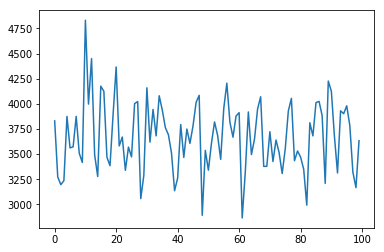

In [30]:
plt.plot(losses)
plt.show()

In [ ]:
print(loss(epoch))

In [ ]:
test = model()

In [ ]:
test.train(2)

In [ ]:
def P(self, rho, z, z_pred):
    if z > z_pred:
        return rho*(z-z_pred)
    else:
        return (1-rho)*(z_pred-z)